# Прогноз времени на эксперимент
- Способы определения объема выборки для A/B-тестов
- Мощность эксперимента

## 2 способа определения необходимого времени на эксперимент
- Fixed Horizon
    - Простая реализация. Высокая ошибка ранней остановки
- Sequential testing
    - Сложная реализация. Оптимизация «проблемы погдлядывания»

### Fixed Horizon
1. Заранее рассчитали требуемую выборку
    - для этого нам надо знать
        - Мощность TP
        - Уровень значимости TN
        - Минимально допустимый эффект MDE
2. Накопили достаточно статистики
3. Посчитали стат. критерий и определили p-value
4. Сделали вывод о возможности отвергнуть нулевую гипотезу

#### Уровень значимости
Ошибка I рода<br>
Показывает вероятность ошибочно отвергнуть нулевую гипотезу и зафиксировать эффект как значимый
> Ложноположительный эффект (False Positive)

#### Мощность (чувствительность)
Ошибка II рода<br>
Показывает вероятность ошибочно принять нулевую гипотезу об отсутствии значимого эффекта
> Ложноотрицательный эффект (False Negative)

##### Помимо MDE также еще учитывают Lift и ES (Effect Size)

##### Lift
Показывает на сколько процентов выросла метрика
<br><br>
$$
\frac{Test-Control}{Control}
$$

##### Effect Size
Степень отклонения наблюдаемых значений от тех, которые можно было бы наблюдать при отсутствии эффекта
<br><br>
$$
\frac{Y_{test}-Y_{control}}{\sigma}
$$
<br>
где 
$$
\sigma=\frac{\sigma_{test}+\sigma_{control}}{2}
$$

#### Минимально допустимый эффект (MDE)
Изменения метрики *(абсолютные/относительные)*, которые мы бы хотели увидеть с заданными порогами ошибок I и II рода<br>
Наименьший истинный эффект полученный от изменений, который имеет определенный уровень стат. мощности для определенного уровня стат. значимости с учетом определенного критерия 
- MDE рассчитывается для каждого стат. критерия по своей формуле
    - Исключение только непараметрические критерии
    - Поскольку для расчета MDE используется дисперсия, для каждого распределения она будет немного изменять формулу. А в непараметрике используются ранги, которые в целом всегда одинаковы. Поэтому они не изменяют действующую формулу
    
###### Формула MDE для t-теста
$$
M*\frac{S}{Y_c}
$$
где
$$
M = t_{alpha / 2} + t_{\beta}
$$
<br>
$$
S = \sqrt{\frac{\sigma_{test}^2}{n_{test}} + \frac{\sigma_{conrol}^2}{n_{control}}}
$$

#### Как считать N?
Можно сделать это на основе предрасчитанного Effect Size (размера эффекта при отсутствии эффекта)
- Формула работает для сбалансированных выборок 50/50. Поэтому идет умножение на 2, чтобы получить объем двух выборок. Для других сплитов используются модификации этой формулы
- В Effect Size подставляется абсолютное значение, а не проценты
<br><br>
$$
n = 2 * (t_{\alpha/2} + t_{\beta})^2 * \frac{\sigma^2}{Effect Size^2}
$$

#### Как интерпретировать MDE
- Сравниваем Lift по метрике и MDE
    - Если Lift меньше MDE (при $p-value$ < $alpha$), то мы не можем принять этот эффект. Поскольку фактический эффект ниже того, что мы реально можем задетектировать
    - Если Lift больше MDE (при $p-value$ < $alpha$), то мы принимаем этот эффект.
    
> Если $p-value$ > $alpha$, то это не означает отсутствие эффекта. Эффект может быть, но больше чем MDE

In [545]:
import pandas as pd
import numpy as np

import datetime as dt
import math

import statsmodels.stats.power as smp
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm.auto import tqdm

### Для каждого стат. критерия существует своя функция MDE
В эту функцию вносятся 3 любые переменные, чтобы получить четвертую
##### Параметры
- alpha
- power
- nobs1 (кол-во наблюдений 1 группы; кол-во наблюдений 2 группы задается как доля в ratio)
- effect size
- ratio (по умолчанию 1 для 1 sample; задается доля 2 группы относительно группы 1)

In [539]:
# Пример для z-теста для пропорций

ax = 312
ay = 487
nx = 1234
ny = 1646

px = ax/nx
py = ay/ny

alpha = .05
power = .8

print(f'Px: {px:.2f}, Py: {py:.2f}')

Px: 0.25, Py: 0.30


In [540]:
effect_size = smp.zt_ind_solve_power(
    alpha=alpha,
    power=power,
    nobs1=nx,
    ratio=ny/nx
)
print(f'effect_size: {effect_size:.4f}')

effect_size: 0.1055


In [541]:
nobs1 = smp.zt_ind_solve_power(
    alpha=alpha,
    power=power,
    effect_size=0.1055,
    ratio=ny/nx
)
print(f'nobs1: {nobs1:.4f}')

nobs1: 1233.8556


In [542]:
power = smp.zt_ind_solve_power(
    alpha=alpha,
    effect_size=0.1055,
    nobs1=nx,
    ratio=ny/nx
)
print(f'power: {power:.4f}')

power: 0.8000


#### Как изменяется параметр effect_size в зависимости от увеличения объема выборки?
- Посмотрим на примере t-теста

In [543]:
effect_size = []

for n in tqdm(range(10, 10000)):
    es = smp.tt_ind_solve_power(
        alpha=.05,
        power=.08,
        nobs1=n
    )
    effect_size.append(es)

100%|██████████████████████████████████████| 9990/9990 [00:52<00:00, 188.87it/s]


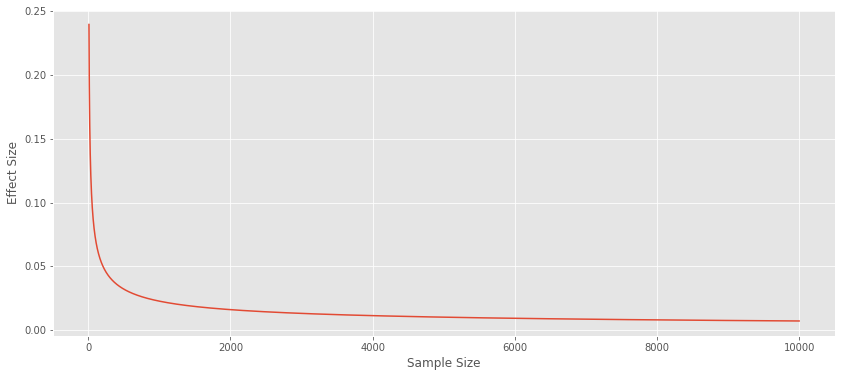

In [544]:
plt.figure(figsize=(14,6))
viz = sns.lineplot(x=range(10,10000), y=effect_size)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Size");

#### Как еще можно определять effect_size для t-теста и на его основе кол-во наблюдений?

In [ ]:
mean = 2021.989 # рассчитанное среднее за 2-5 недель
se = 2425.011 # рассчитанное стандартное отклонение за тот же период

power = 0.9
alpha = 0.005

lift = 0.1 # хотим увидеть 10% изменение в метрику
effect_size = mean / se * lift 
print(effect_size)

In [ ]:
# Результат – наблюдения на одну выборку (соотвественно, умножаем на 2)
n = smp.tt_ind_solve_power(
    effect_size=effect_size, 
    alpha=alpha, 
    power=power, 
    nobs1=None, # искомую величину можно определять как None
    ratio=1
)
print(f'Кол-во наблюдений на каждую группу: {n:.2f}')

## Рассчитаем MDE фактический и по ходу эксперимента

#### Сгенерим данные

In [546]:
def data_gen(l, n, k):
    """
        l: длительность эксперимента
        n: кол-во юзеров
        k: коэффициент увеличения группы 2
    """

    # Временной период
    days = []
    for day in range(1,l+1):
        days.append((dt.datetime.today() - dt.timedelta(days=day)).strftime('%Y-%m-%d'))
    
    # Пользователи
    count = n
    users = []
    for user in np.random.randint(10000,90000,count):
        user_id = hash(user)
        users.append(user_id)
    
    # Объедине юзеров по дням
    days_df = pd.DataFrame(days).rename(columns={0:'date'})
    users_df = pd.DataFrame(users).rename(columns={0:'user_id'})
    
    traffic = days_df.merge(
        users_df,
        how='cross'
    )
    
    # Генерация метрики
    metrics = []
    for user in users:
        user_metrics = np.random.exponential(10,14)
        metrics.append(user_metrics)
    
    metric = pd.DataFrame(pd.Series(metrics).explode()).rename(columns={0:'metric'})

    # Объединение метрики и трафика
    data = pd.concat([traffic, metric.set_index(traffic.index)], axis=1)

    # Сплитование юзеров
    split = []
    for user in users:
        group = np.random.randint(1,3)
        split.append(group)
    
    splits = pd.concat(\
        [pd.DataFrame(users).rename(columns={0:'user_id'}), \
         pd.DataFrame(split).rename(columns={0:'split'})], axis=1)
    
    # Финальная сборка
    data = data.merge(
        splits,
        how='left',
        left_on='user_id',
        right_on='user_id'
    )
    
    data.loc[data.split == 2, 'metric'] = data.loc[data.split == 2, 'metric'] * k
    
    return data

In [547]:
data = data_gen(n=6000, l=14, k=1.1)

In [548]:
data.head()

,date,user_id,metric,split
0,2022-05-02,26423,10.42539,2
1,2022-05-02,81448,12.057332,2
2,2022-05-02,50665,0.347365,2
3,2022-05-02,30517,4.487563,1
4,2022-05-02,60113,1.380934,1


#### Расчет MDE по факту проведения эксперимента

##### Этап 1. Расчитаем статистики

In [ ]:
alpha = .05
power = .8

data_stats = data.groupby(['split']).agg({'metric': ['count', 'sum', 'mean', 'std']})
data_stats

##### Этап 2. Рассчитаем MDE
- В данном примере p_value получился ниже 0.05
- А MDE значительно ниже лифта
- Поэтому мы можем зафиксировать получившийся эффект как стат. значимый и отвергнуть нулевую гипотезу

In [520]:
# Рассчтаем стат. критерий на основе статистик
t_stats, p_value = \
sts.ttest_ind_from_stats(
    mean1 = data_stats.metric['mean'][1],
    std1 = data_stats.metric['std'][1],
    nobs1 = data_stats.metric['count'][1],
    mean2 = data_stats.metric['mean'][2],
    std2 = data_stats.metric['std'][2],
    nobs2 = data_stats.metric['count'][2],
    equal_var = False
)

data_stats['p_value'] = p_value

# Lift
data_stats['lift'] = (data_stats.metric['mean'][2] - data_stats.metric['mean'][1]) / data_stats.metric['mean'][1]
# Effect Size
data_stats['effect_size'] = abs(data_stats.metric['mean'][1] / data_stats.metric['std'][1] * data_stats['lift'])

data_stats['mde'] = smp.tt_ind_solve_power(
    alpha=alpha,
    power=power,
    nobs1=data_stats.metric['count'][1],
    ratio=data_stats.metric['count'][1]/data_stats.metric['count'][2]
)

data_stats['n_need'] = smp.tt_ind_solve_power(
    alpha=alpha,
    power=power,
    effect_size=data_stats['effect_size'][1],
    ratio=data_stats.metric['count'][1]/data_stats.metric['count'][2]
)

data_stats.head()

metric                                       p_value  \
                  count           sum       mean        std             
date       split                                                        
2022-04-08 1       3153  31475.004931   9.982558   9.922249  0.000636   
           2       3307  35941.724406  10.868378  11.158529  0.000636   
2022-04-09 1       3153  31410.188217   9.962001  10.152343  0.000636   
           2       3307  36289.429145  10.973520  10.603422  0.000636   
2022-04-10 1       3153  31247.561879   9.910422   9.814650  0.000636   

                      lift effect_size       mde       n_need  
                                                               
date       split                                               
2022-04-08 1     -0.083396    0.081227  0.068099  2324.751317  
           2     -0.083396    0.081227  0.068099  2324.751317  
2022-04-09 1     -0.083396    0.081227  0.068099  2324.751317  
           2     -0.083396    0.081227  0.068099  2324.751317  
2022-04-10 1     -0.083396    0.081227  0.068099  2324.751317

In [532]:
# ttest_ind_from_stats - это функция расчета t теста из агрегированных данных. 
# Результат примерно такой же как и с обычным тестом
sts.ttest_ind(
    data[data.split == 1].metric,
    data[data.split == 2].metric
)

Ttest_indResult(statistic=-14.368350180846953, pvalue=9.206667667688654e-47)

### Рассчитаем MDE по ходу эксперимента

##### Этап 1. Сделаем расчет

In [ ]:
alpha = .05
power = .8

dates = list(set(data.date))

try:
    del data_daily_stats
except:
    pass
    
for date in dates:
    # Расчитаем статистики

    try:
        data_daily_stats.sample(1)
        data_daily_stats_row = data[data.date <= date].\
                    groupby(['split']).agg({'metric': ['count', 'sum', 'mean', 'std']})
        
        data_daily_stats_row['date'] = date
        
        data_daily_stats = pd.concat([data_daily_stats, data_daily_stats_row])
        
    except:
        data_daily_stats = data[data.date <= date].\
                    groupby(['split']).agg({'metric': ['count', 'sum', 'mean', 'std']})
    
        data_daily_stats['date'] = date
        
data_daily_stats = data_daily_stats.sort_values(by=['date', 'split'])
data_daily_stats.head()

##### Этап 2. Рассчитаем MDE

In [506]:
p_value_list = []
lift_list = []
es_list = []
mde_list = []
n_need_list = []

for date in dates:
    
    # Рассчтаем стат. критерий на основе статистик
    t_stats, p_value = \
    sts.ttest_ind_from_stats(
        mean1 = data_daily_stats[data_daily_stats.date == date].metric['mean'][1],
        std1 = data_daily_stats[data_daily_stats.date == date].metric['std'][1],
        nobs1 = data_daily_stats[data_daily_stats.date == date].metric['count'][1],
        mean2 = data_daily_stats[data_daily_stats.date == date].metric['mean'][2],
        std2 = data_daily_stats[data_daily_stats.date == date].metric['std'][2],
        nobs2 = data_daily_stats[data_daily_stats.date == date].metric['count'][2],
        equal_var = False
    )
    p_value_list.append(p_value)

    # Lift
    lift = (data_daily_stats[data_daily_stats.date == date].metric['mean'][2] - data_daily_stats[data_daily_stats.date == date].metric['mean'][1]) / data_daily_stats[data_daily_stats.date == date].metric['mean'][1]
    # Effect Size
    effect_size = abs(data_daily_stats[data_daily_stats.date == date].metric['mean'][1] / data_daily_stats[data_daily_stats.date == date].metric['std'][1] * lift)

    lift_list.append(lift)
    es_list.append(effect_size)
    
    mde = smp.tt_ind_solve_power(
        alpha=alpha,
        power=power,
        nobs1=data_daily_stats[data_daily_stats.date == date].metric['count'][1],
        ratio=data_daily_stats[data_daily_stats.date == date].metric['count'][1]/data_daily_stats[data_daily_stats.date == date].metric['count'][2]
    )
    
    mde_list.append(mde)

    n_need = smp.tt_ind_solve_power(
        alpha=alpha,
        power=power,
        effect_size=effect_size,
        ratio=data_daily_stats[data_daily_stats.date == date].metric['count'][1]/data_daily_stats[data_daily_stats.date == date].metric['count'][2]
    )

    n_need_list.append(n_need)
    
result_stats = pd.DataFrame({
    'date': dates,
    'p_value': p_value_list,
    'lift': lift_list,
    'effect size': es_list,
    'mde': mde_list,
    'n_need': n_need_list,  
}).sort_values(by='date')

In [507]:
result_stats

,date,p_value,lift,effect size,mde,n_need
9,2022-04-08,7.417310e-04,0.088737,0.089276,0.071427,2018.629069
12,2022-04-09,2.594183e-07,0.095131,0.094516,0.050505,1801.129378
4,2022-04-10,7.078555e-13,0.108332,0.108208,0.041235,1374.375774
1,2022-04-11,1.771056e-13,0.095406,0.095623,0.035709,1759.685496
0,2022-04-12,6.908549e-17,0.096867,0.097005,0.031939,1709.915958
8,2022-04-13,5.425288e-19,0.094232,0.094574,0.029156,1798.906773
2,2022-04-14,2.455451e-22,0.095436,0.095734,0.026993,1755.597997
10,2022-04-15,8.728942e-26,0.096364,0.096780,0.025251,1717.873487
5,2022-04-16,2.862172e-28,0.095531,0.095822,0.023805,1752.375433
7,2022-04-17,8.400882e-30,0.093221,0.093475,0.022585,1841.427883


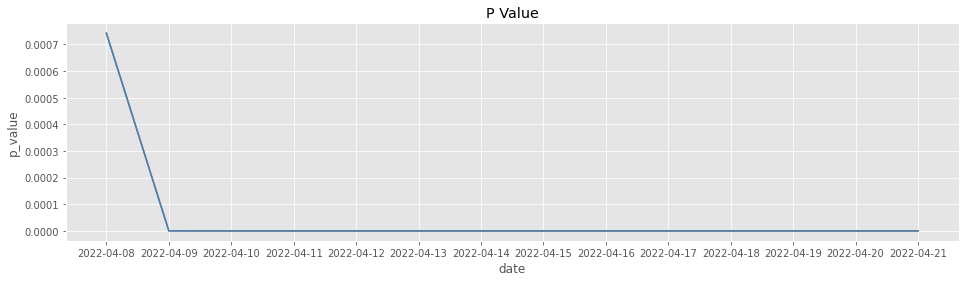

In [515]:
plt.figure(figsize=(16,4))
sns.lineplot(
    data=result_stats,
    x='date',
    y='p_value'
).set(title='P Value');

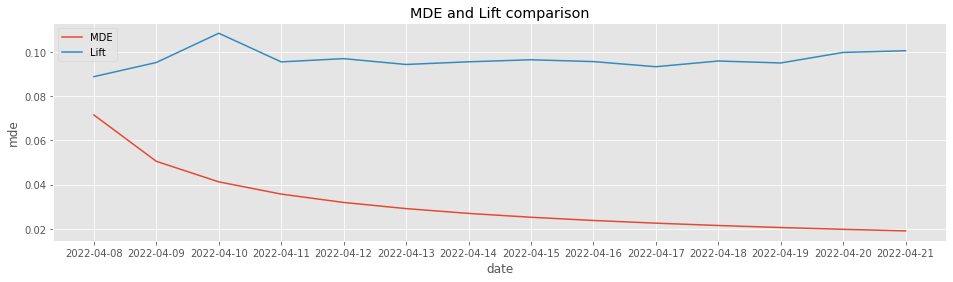

In [531]:
plt.figure(figsize=(16,4))
sns.lineplot(
    data=result_stats,
    x='date',
    y='mde',
    label='MDE'
).set(title='MDE and Lift comparison')
sns.lineplot(
    data=result_stats,
    x='date',
    y='lift',
    label='Lift'
)
plt.legend();